<a href="https://colab.research.google.com/github/giutassarotti/testia/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r requirements.txt

# **Caricamento del dataframe**

In [23]:
import pandas

def io_load_multiple_csv(csv_path_list):
  dataframe_list = []
  for elem in csv_path_list:
    dataframe_list.append(io_load_csv(elem))
  return dataframe_list

def io_load_csv(csv_path):
  return pandas.read_csv(csv_path)

In [24]:
dataframe_train_path = "train.csv"
dataframe_test_path = "test.csv"

dataframe_train, dataframe_test = io_load_multiple_csv([dataframe_train_path, dataframe_test_path])
dataframe_train.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,3144-KMTWZ,Male,0,Yes,No,71,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),93.25,6669.45
1,No,5821-MMEIL,Female,0,Yes,No,57,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.90,1115.6
2,No,7219-TLZHO,Female,0,Yes,Yes,4,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.85,62.9
3,No,1930-WNXSB,Male,0,Yes,Yes,58,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,92.85,5305.05
4,Yes,5889-JTMUL,Female,1,Yes,No,50,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,95.05,4888.7


# **Analisi del dataset**
## **Filtraggio dei valori nulli**

Nell'analisi del dataframe si scopre che la colonna TotalCharges ha dei valori mancanti. Per mantenere il riconoscimenti in numerale, questi vengono trasformati in NaN.


In [47]:
import numpy

def to_float(number):
  try:
    return numpy.float(number)
  except: 
    return numpy.nan

def filter_nan(dataframe, column):
  dataframe[column].apply(to_float)
  dataframe[column]= pandas.to_numeric(dataframe[column])

  return dataframe

In [48]:
dataframe_train = filter_nan(dataframe_train, "TotalCharges")
dataframe_test = filter_nan(dataframe_test, "TotalCharges")

## **Analisi del dataframe**
Definiamo ora le funzioni utili ad analizzare il dataframe fornito.

In [39]:
def print_infos(dataframe):
  print("Dataframe miscellaneous:\n")
  print("Rows     : {}".format(dataframe.shape[0]) )
  print("Columns  : {}".format(dataframe.shape[1]))
  print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
  print("\nUnique values :\n{}".format(dataframe.nunique()))

  print("\nDataframe info:")
  dataframe.info()

In [35]:
import matplotlib.pyplot as pyplot
import seaborn

def is_categorical(elem):
  return type(elem) is str

def is_numeric(elem):
  return not is_categorical(elem)

def get_numeric_features(dataframe):
  numeric_features = []
  for elem in dataframe:
    if is_numeric(dataframe[elem][0]):
      numeric_features.append(elem)
  return numeric_features

def get_categorical_features(dataframe):
  categorical_features = []
  for elem in dataframe:
    if is_categorical(dataframe[elem][0]):
      categorical_features.append(elem)
  return categorical_features

def print_feature_plots(dataframe, feature_target):
  categorical_features = get_categorical_features(dataframe)
  print(categorical_features)
  numeric_features = get_numeric_features(dataframe)
  print(numeric_features)
  for elem in dataframe:
    if elem in categorical_features:
      #Categorical
      plot = seaborn.catplot(x = feature_target, 
                        col = elem, 
                        data = dataframe, 
                        kind = 'count')
    elif elem in numeric_features:
      #Numeric
      plot = seaborn.displot(data = dataframe,
                        x = elem,
                        hue = feature_target) 
  
    pyplot.show()

def remove_columns(dataframe, column_list):
  for elem in column_list:
    dataframe.pop(elem)
  return dataframe

# **Modello**
Vengono sfruttate le possiilità offerte da una pipeline di sklearn per creare ed utilizzare il modello.

Come classificatore viene utilizzato l'algoritmo di Random Forest, che è un algoritmo di tipo Ensemble, e quindi sfrutta la combinazione di altri algoritmi più deboli ma opportunamente organizzati ed utilizzati per ottenere dei risultati soddisfacenti. In questo caso abbiamo una combinazione di classificatori di tipo Decision tree.

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, plot_confusion_matrix

def create_preprocessor(dataframe):
  numeric_features = get_numeric_features(dataframe)
  numeric_transformer = Pipeline(
      steps = [('imputer', SimpleImputer(strategy='median')),
               ('scaler', StandardScaler())])

  categorical_features = get_categorical_features(dataframe)
  categorical_transformer = Pipeline(
      steps=[('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  return ColumnTransformer(
      transformers=[('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

def create_model(dataframe):
  preprocessor = create_preprocessor(dataframe)

  return Pipeline(
      steps = [('preprocessor', preprocessor),
               ('classifier', RandomForestClassifier())])
  
def train_model(model, dataframe_train, dataframe_train_target):
  model.fit(dataframe_train, dataframe_train_target)
  print('Training score: {}'.format(model.score(dataframe_train, dataframe_train_target)))
  return model

def print_test_model(model, dataframe_test, dataframe_test_target):
  preds = model.predict(dataframe_test)
  print('Test score: {}'.format(model.score(dataframe_test, dataframe_test_target)))
  print(classification_report(dataframe_test_target, preds))

# **Esecuzione**
*Impostazioni di stampa*

In [30]:
numpy.set_printoptions(precision=3, suppress=True)

*Caricamento del dataset*

In [49]:
print_infos(dataframe_train)

Dataframe miscellaneous:

Rows     : 4507
Columns  : 20

Features :
['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Unique values :
Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1398
TotalCharges        4277
dtype: int64

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
D

['Churn', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


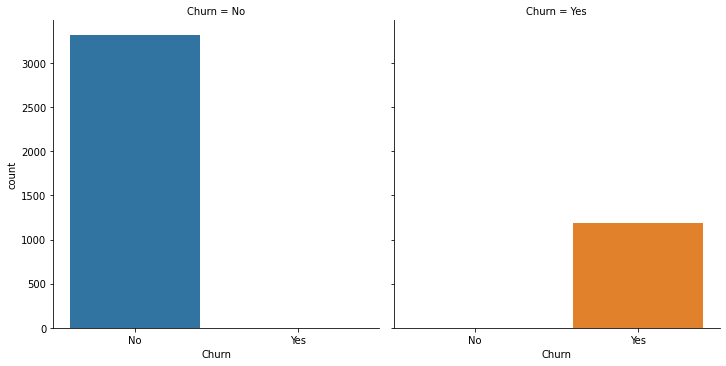

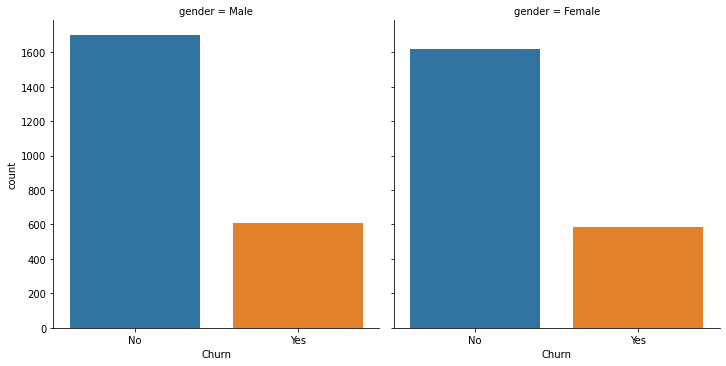

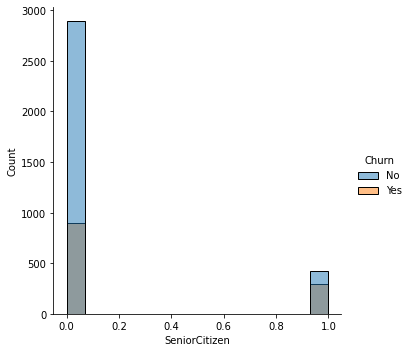

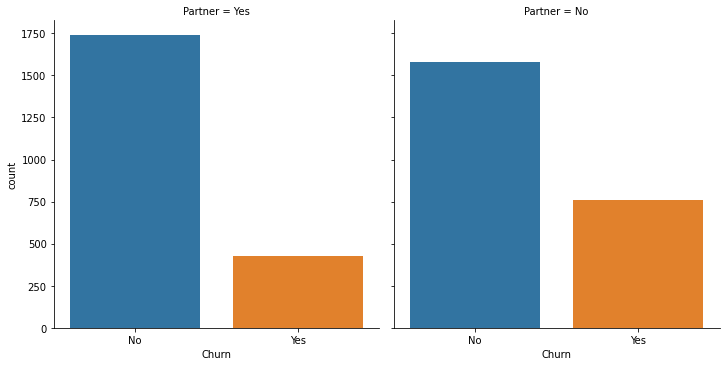

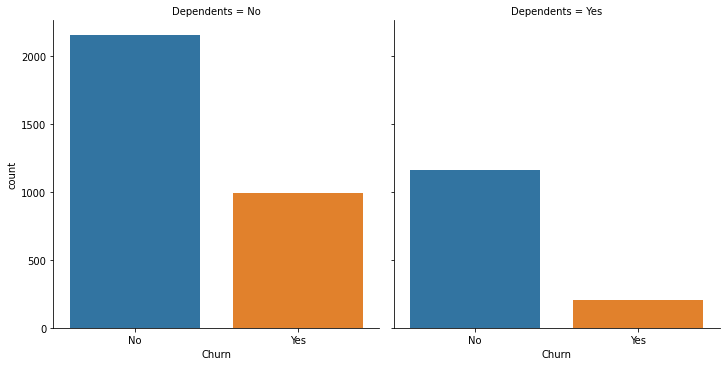

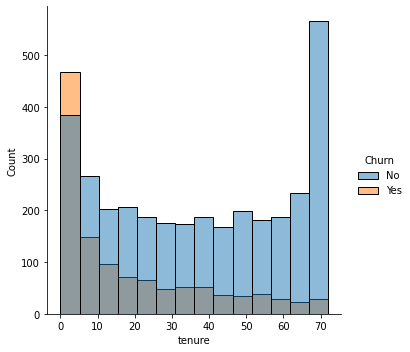

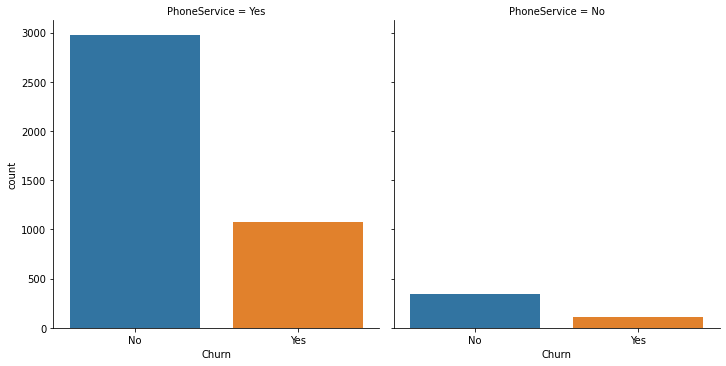

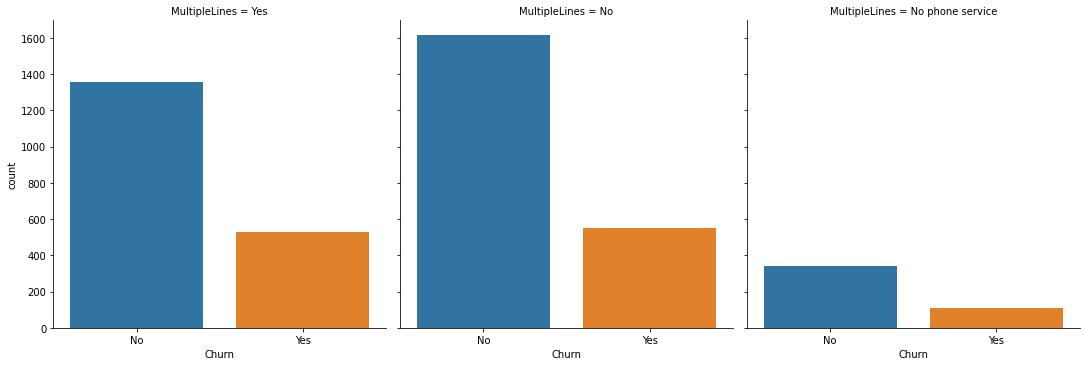

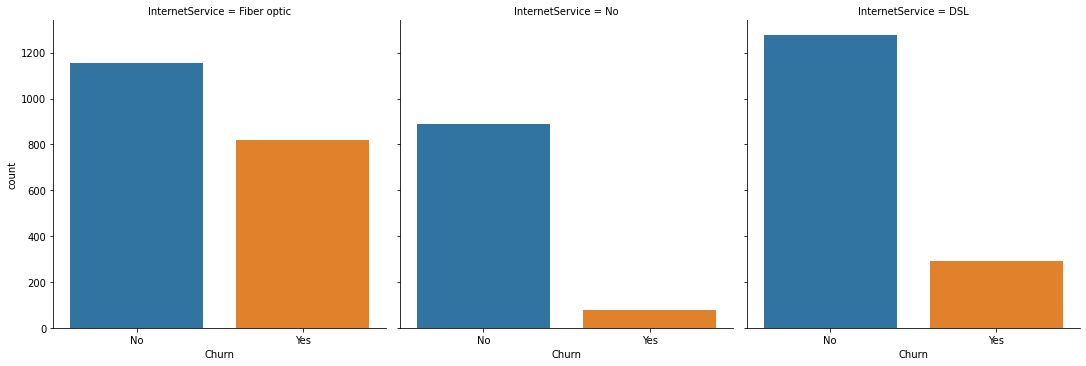

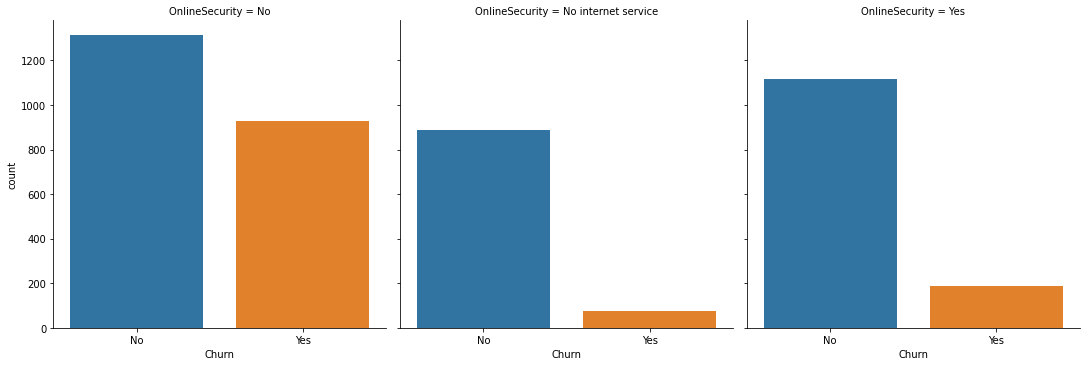

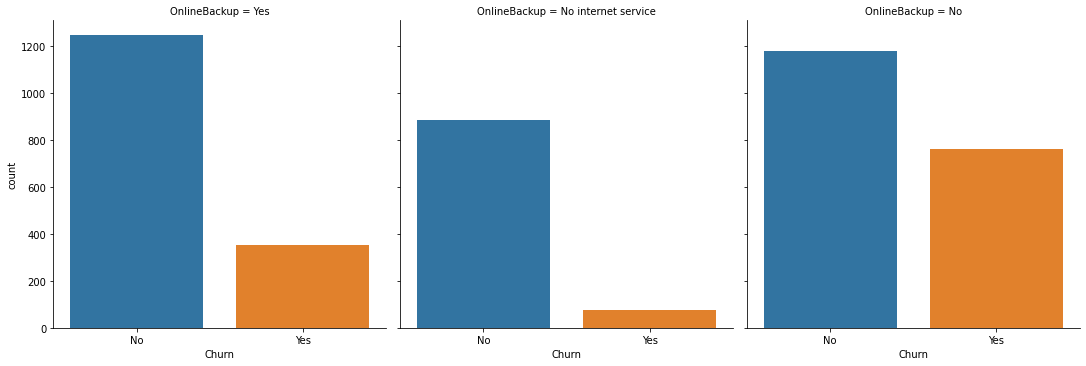

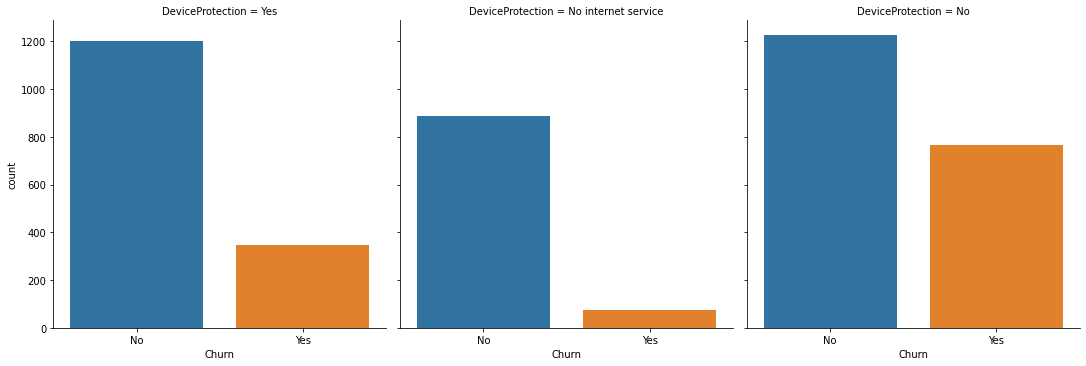

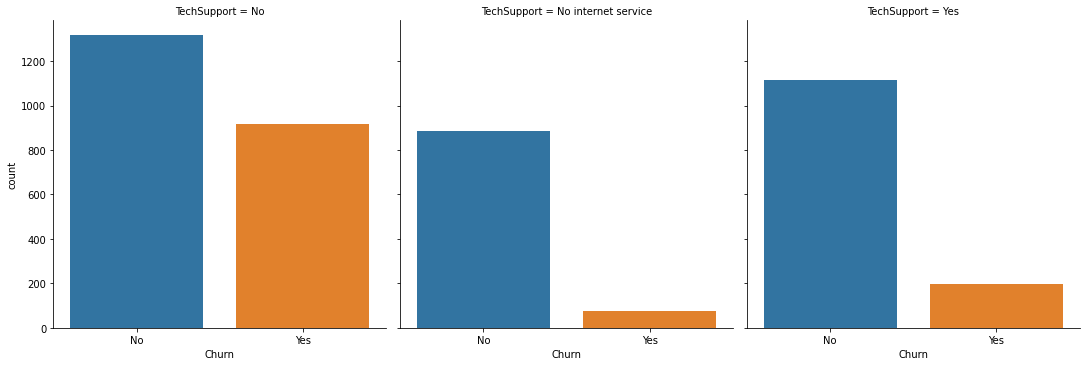

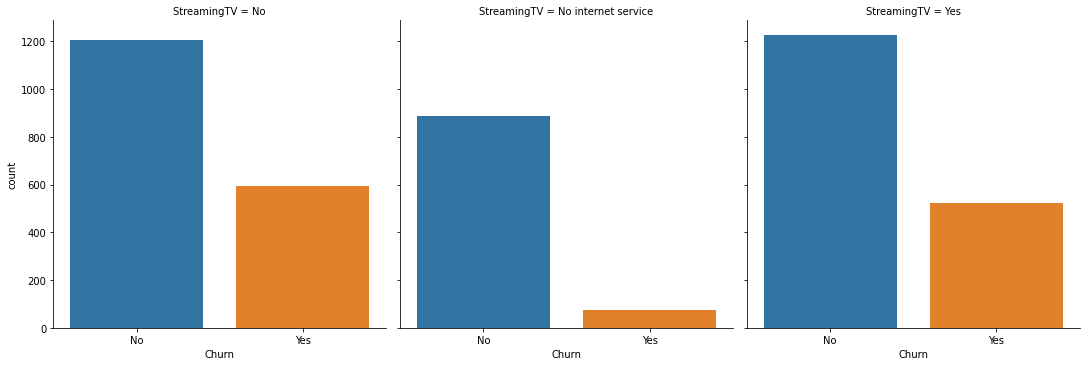

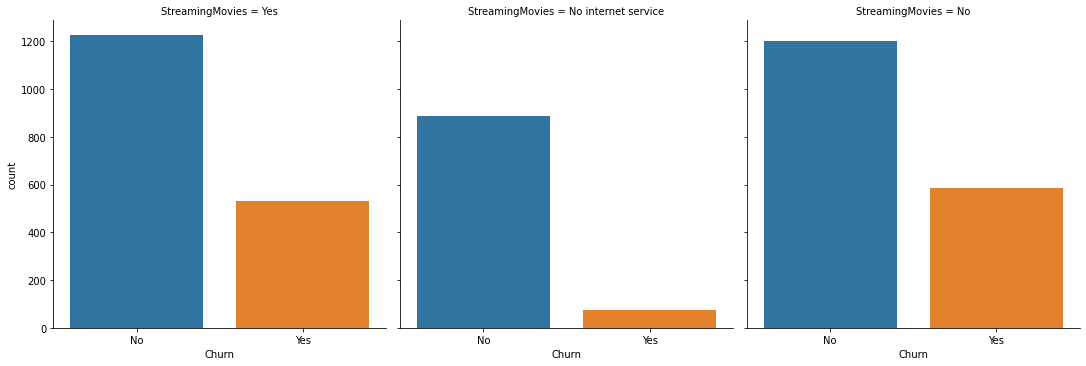

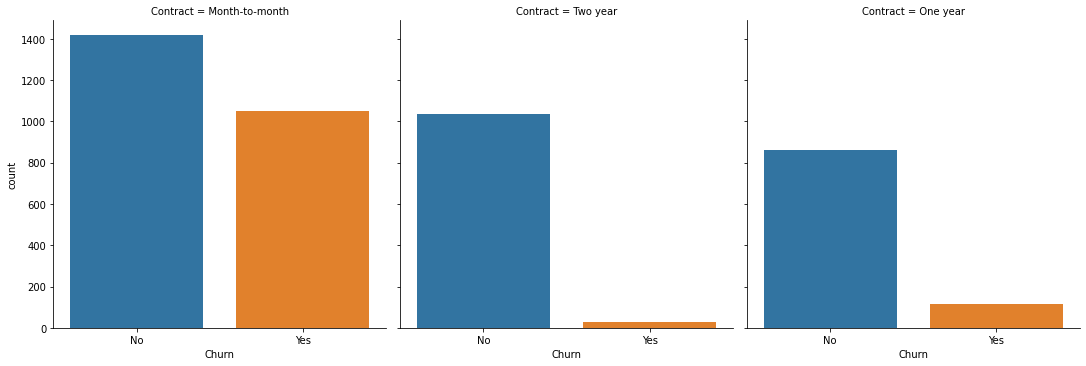

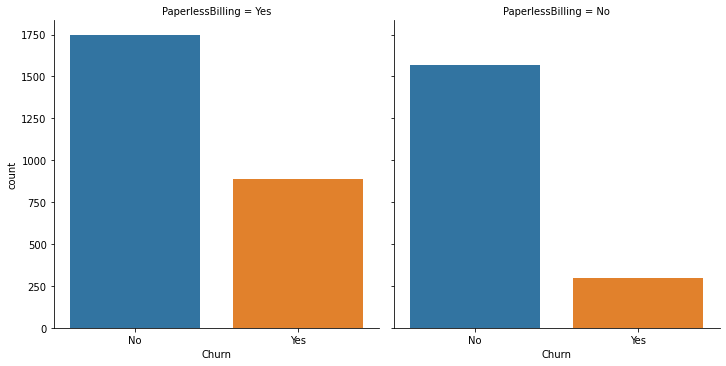

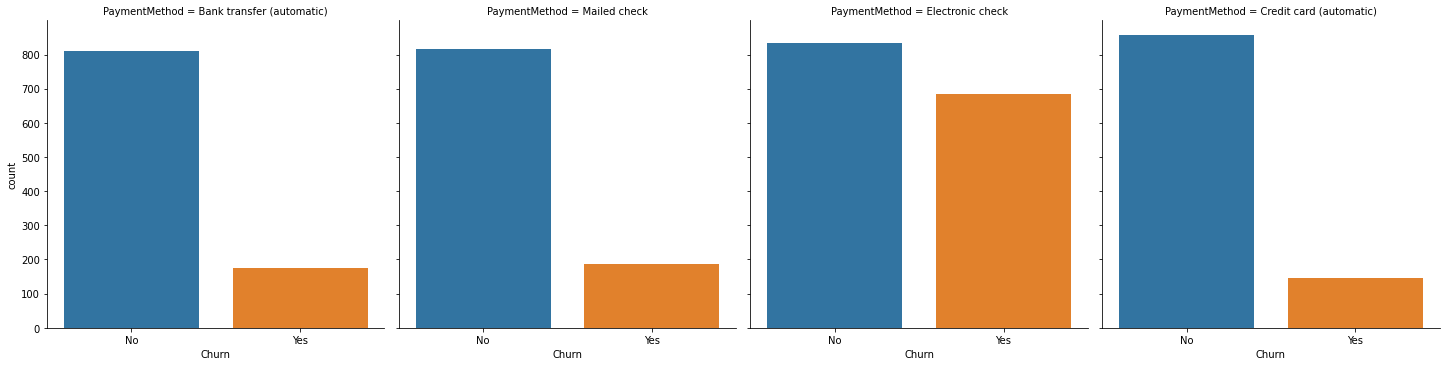

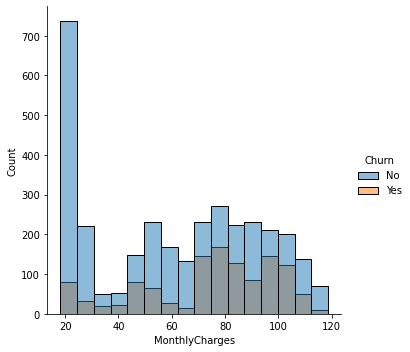

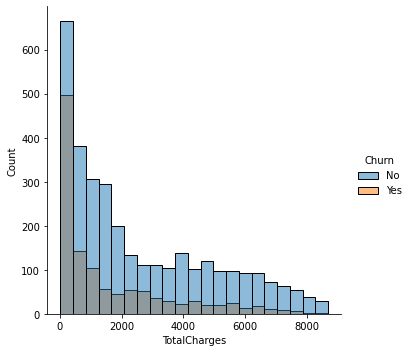

In [50]:
feature_target = "Churn"
train_copy = dataframe_train
#del train_copy["customerID"]
print_feature_plots(train_copy, feature_target)

In [41]:
pandas.to_numeric(dataframe_train["TotalCharges"])

0       6669.45
1       1115.60
2         62.90
3       5305.05
4       4888.70
         ...   
4502     577.60
4503    6083.10
4504    5073.10
4505    1346.90
4506     930.95
Name: TotalCharges, Length: 4507, dtype: float64